In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append("../BBTRE_physics_analysis/") 

In [3]:
import numpy as np
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [4]:
def checklist(gridscale):
    return f"""Checklist for running variable resolution experiments:

Directory structure:
  [x] Copy input and code files from reference simulation
  [x] Run Jupyter notebook to create input files

/code files:
  SIZE.h
    [ ] Change resolution and MPI partitioning in SIZE.h file

[ ] Re-compile

/input files:
  data
    [ ] Multiply 1st term in delX and delY by {1/gridscale} and 2nd by {gridscale}
    [ ] Multiply deltaT by {gridscale} and nTimesteps by {1/gridscale}
    [ ] Multiply viscA4 and diffK4T parameters by {gridscale}^4
    [ ] Possibly change runtime, depending on whether or not you think the run will finish
  data.diagnostics
    [ ] Turn off all diagnostics except UVEL, VVEL, WVEL, THETA in levelDiag, and
        UVEL, VVEL, WVEL, THETA, DRHODR, ADVr_TH in meanDiag
  execution script
    [ ] Check that number of processors and nodes is consistent with SIZE.h code file

[ ] Submit execution batch script
[ ] Check that the job runs succesfully!
"""

In [5]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = 5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.
delta_t = 30.

In [16]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_idealized-plane/run/"
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
ds = ds.isel(time=0)
ds, grid = add_rotated_coords(ds, θ)

geo = xr.open_dataset(data_dir+"geocoords.nc")
ds['Depth_actual'] = xr.zeros_like(ds['Depth']) - geo['z_actual'].values

dx = 600.; dy = 600.;
Ly = ds.YC.size*dy
Lx = ds.XC.size*dx

ds.attrs["dx"] = dx;
ds.attrs["dy"] = dy;
ds.attrs["Lx"] = Lx;
ds.attrs["Ly"] = Ly;

ds = ds.assign_coords({"Depth": -ds.Depth})

In [17]:
def regrid(ds, gridscale):
    if gridscale>1:
        new_ds = ds.coarsen({"XC": gridscale, "XG": gridscale, "YC": gridscale, "YG": gridscale}, boundary="trim").mean()
    if gridscale<1:
        tmp_ds = ds.copy()
        extend_multiples = [-1, 1]
        tmp_ds = periodic_extend(tmp_ds, ['XC', 'XG'], dx*tmp_ds.XC.size, extend_multiples)
        tmp_ds = periodic_extend(tmp_ds, ['YC', 'YG'], dy*tmp_ds.YC.size, extend_multiples)
        tmp_ds = tmp_ds.chunk({"XC":-1, "YC":-1, "XG":-1, "YG":-1})
        new_coords = {
            "XC": np.arange(ds.dx*gridscale/2, ds.Lx, ds.dx*gridscale),
            "XG": np.arange(0, ds.Lx, ds.dx*gridscale),
            "YC": np.arange(ds.dy*gridscale/2, ds.Ly, ds.dy*gridscale),
            "YG": np.arange(0, ds.Ly, ds.dy*gridscale), 
        }
        new_coords = xr.Dataset({}, new_coords)
        new_ds = tmp_ds.interp_like(new_coords, method="linear")
    return new_ds

In [18]:
gridscales = [0.5, 2, 4, 8]

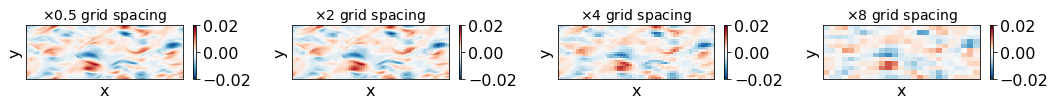

In [19]:
plt.figure(figsize=(15, 1.75))
for (i, gridscale) in enumerate(gridscales):
    new_ds = regrid(ds, gridscale)
    plt.subplot(1,len(gridscales), i+1)
    q = new_ds.UVEL.isel(Z=-40).plot(vmin=-0.02, vmax=0.02, cmap=div_cmap)
    q.colorbar.set_label("")
    plt.title(fr"$\times${gridscale} grid spacing", fontsize=14)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

### Create input files from last snapshot of model output

In [20]:
input_vars = {
    "UVEL": "U",
    "VVEL": "V",
    "THETA": "T",
    "KVDIFF": "kappa",
    "Depth": "topog",
    "drF": "delZ"
}

for gridscale in gridscales:
    input_path = f"../../MITgcm/experiments/rotated_BBTRE_idealized-plane-{gridscale}x/input/"
    print(f"\n{input_path}")
    new_ds = regrid(ds, gridscale)
    
    for (k, v) in input_vars.items():
        # save input data as binary files
        newFile = open(f"{input_path}{v}.init", "wb")
        newFile.write(bytes(new_ds[k].values.astype('>f8')))
        newFile.close()
    
    checklist_name = f"{input_path}checklist.txt"
    if not(os.path.exists(checklist_name)):
        f = open(checklist_name, "w")
        f.write(checklist(gridscale))
        f.close()
    else:
        print(" (Checklist file already exists!)")
        
    os.system(f"cp ./resolution_changes.ipynb {input_path}");


../../MITgcm/experiments/rotated_BBTRE_idealized-plane-0.5x/input/
 (Checklist file already exists!)

../../MITgcm/experiments/rotated_BBTRE_idealized-plane-2x/input/
 (Checklist file already exists!)

../../MITgcm/experiments/rotated_BBTRE_idealized-plane-4x/input/
 (Checklist file already exists!)

../../MITgcm/experiments/rotated_BBTRE_idealized-plane-8x/input/
 (Checklist file already exists!)
